In [1]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

lemmatizer = WordNetLemmatizer()
REMOVEABLE_CHARS = "»<>123456789\/&()?:!.,;'´"
ALL_TAGS = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VBD', 'VBG', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
MAX_FEATURES = 1000
MIN_ENGLISH = 0.9999
LIMIT_INPUT_ROWS = 500 # to stop run times hindering development (making this < 500 usually makes the graph angry)

def get_wordnet_pos(tag): # Return a char, based on input tag, that is used as a param in lemmatisation for enhanced results
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= [];
with open ('reviews.json', 'rb') as f:
    for i, item in enumerate(json_lines.reader(f)):
        if i <= LIMIT_INPUT_ROWS:
            try:
                langs = detect_langs(item['text'])
            except:
                pass
            for i, lang in enumerate(langs):
                if str(lang)[0:2] == 'en':
                    if float(str(lang)[3:]) > MIN_ENGLISH:
                        reviews.append(item['text'])
                        polarity.append(item['voted_up'])
                        are_early.append(item['early_access'])

In [3]:
# for i, item in enumerate(reviews):
#     print( "reviews[", str(i), "]: ", str(reviews[i]) )
#     print( "polarity[", str(i), "]: ", str(polarity[i]) )
#     print( "are_early[", str(i), "]: ", str(are_early[i]) )
#     print( "\n" )

In [4]:
# FILTER TEXT
for i, text in enumerate(reviews):
    text_words = nltk.word_tokenize(text.lower())
    tags = nltk.pos_tag(text_words)
    #print(tags)
    new_text= [];
    for j, word in enumerate(text_words):
        if tags[j][1] in ALL_TAGS:
            for char in word:
                if char in REMOVEABLE_CHARS:
                    break
            else:
                wordnet_pos = get_wordnet_pos(tags[j][1])
                if wordnet_pos != '':
                    new_text.append(lemmatizer.lemmatize(word, wordnet_pos))
                continue
    reviews[i] = new_text

for i, text in enumerate(reviews): 
    new_text= [];
    tags = nltk.pos_tag(reviews[i])
    for j, word in enumerate(text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    reviews[i] = new_text
    #print(tags)

In [5]:
# for i, item in enumerate(reviews):
#     print( "reviews[", str(i), "]: ", str(reviews[i]) )
#     print( "polarity[", str(i), "]: ", str(polarity[i]) )
#     print( "are_early[", str(i), "]: ", str(are_early[i]) )
#     print( "\n" )

In [6]:
# MOST FREQ WORDS AS FEATURES
word_counts = {};
for text in reviews:
    for word in text:
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts = {}
if len(word_counts) > MAX_FEATURES:
    for i, entry in enumerate(word_counts):
        if i >= MAX_FEATURES:
            break
        trimd_word_counts[entry] = word_counts[entry]
word_counts = trimd_word_counts

tags = nltk.pos_tag(word_counts.keys()); # this part is just for the below print statement
for i, word in enumerate(word_counts):
    print("word: ", word, "| tag: ", tags[i][1], "| count: ",word_counts[word],"\n")

word:  game | tag:  NN | count:  298 

word:  i | tag:  NN | count:  110 

word:  story | tag:  NN | count:  43 

word:  play | tag:  NN | count:  42 

word:  time | tag:  NN | count:  32 

word:  way | tag:  NN | count:  27 

word:  player | tag:  NN | count:  25 

word:  character | tag:  NN | count:  25 

word:  more | tag:  RBR | count:  23 

word:  thing | tag:  NN | count:  22 

word:  choice | tag:  NN | count:  20 

word:  world | tag:  NN | count:  19 

word:  friend | tag:  VBP | count:  18 

word:  hour | tag:  NN | count:  17 

word:  look | tag:  NN | count:  17 

word:  get | tag:  NN | count:  17 

word:  fun | tag:  VB | count:  17 

word:  up | tag:  RP | count:  16 

word:  out | tag:  RP | count:  16 

word:  most | tag:  JJS | count:  14 

word:  point | tag:  JJ | count:  14 

word:  defiance | tag:  NN | count:  14 

word:  weapon | tag:  IN | count:  13 

word:  gameplay | tag:  JJ | count:  13 

word:  people | tag:  NNS | count:  13 

word:  experience | tag:  

word:  issue | tag:  NN | count:  2 

word:  tribe | tag:  NN | count:  2 

word:  frustrating | tag:  VBG | count:  2 

word:  zombie | tag:  NNS | count:  2 

word:  twist | tag:  JJ | count:  2 

word:  company | tag:  NN | count:  2 

word:  employee | tag:  NN | count:  2 

word:  wont | tag:  NN | count:  2 

word:  star | tag:  NN | count:  2 

word:  heart | tag:  NN | count:  2 

word:  alright | tag:  VBD | count:  2 

word:  library | tag:  JJ | count:  2 

word:  brain | tag:  NN | count:  2 

word:  training | tag:  NN | count:  2 

word:  goal | tag:  NN | count:  2 

word:  ore | tag:  IN | count:  2 

word:  item | tag:  NN | count:  2 

word:  dungeon | tag:  NN | count:  2 

word:  crash | tag:  NN | count:  2 

word:  pew | tag:  NN | count:  2 

word:  shot | tag:  NN | count:  2 

word:  * | tag:  NNP | count:  2 

word:  computer | tag:  NN | count:  2 

word:  racing | tag:  VBG | count:  2 

word:  run | tag:  VB | count:  2 

word:  controller | tag:  NN | coun


word:  laugh | tag:  IN | count:  1 

word:  share | tag:  NN | count:  1 

word:  farm | tag:  NN | count:  1 

word:  â€œfirstsâ€ | tag:  NNP | count:  1 

word:  dozen | tag:  NN | count:  1 

word:  hundred | tag:  VBD | count:  1 

word:  plague | tag:  JJ | count:  1 

word:  ward | tag:  JJ | count:  1 

word:  resist | tag:  NN | count:  1 

word:  gabennnnnnnnnn | tag:  NN | count:  1 

word:  euehhehehehe | tag:  NN | count:  1 

word:  sexy | tag:  NN | count:  1 

word:  sticker | tag:  NN | count:  1 

word:  duels | tag:  NNS | count:  1 

word:  entertain | tag:  VBP | count:  1 

word:  west | tag:  JJ | count:  1 

word:  outlaw | tag:  NN | count:  1 

word:  history | tag:  NN | count:  1 

word:  shout | tag:  NN | count:  1 

word:  soldier | tag:  JJR | count:  1 

word:  +++++ | tag:  JJ | count:  1 

word:  list | tag:  NN | count:  1 

word:  hop | tag:  NN | count:  1 

word:  hardcore | tag:  NN | count:  1 

word:  puzzler | tag:  NN | count:  1 

word:  b

word:  lover | tag:  NN | count:  1 

word:  +still | tag:  NNP | count:  1 

word:  -many | tag:  NNP | count:  1 

word:  buggs | tag:  VBD | count:  1 

word:  remaster | tag:  JJR | count:  1 

word:  aoe-lovers | tag:  NNS | count:  1 

word:  empire | tag:  VBP | count:  1 

word:  download-pack | tag:  NN | count:  1 

word:  chill | tag:  NN | count:  1 

word:  xen | tag:  NNP | count:  1 

word:  hail | tag:  NN | count:  1 

word:  blatant | tag:  NN | count:  1 

word:  weeaboo | tag:  NN | count:  1 

word:  humor | tag:  NN | count:  1 

word:  hacker | tag:  NN | count:  1 

word:  stake | tag:  NN | count:  1 

word:  reader | tag:  NN | count:  1 

word:  introduce | tag:  VBZ | count:  1 

word:  deeper | tag:  JJR | count:  1 

word:  mystery | tag:  NN | count:  1 

word:  question | tag:  NN | count:  1 

word:  repetition | tag:  NN | count:  1 



In [7]:
# CREATE 1-HOT ENCODINGS
one_hots = [];
for text in reviews:
    one_hot = [];
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text:
        if word in word_counts:
            one_hot[list(word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
one_hots = np.array(one_hots)

0.8285714285714286


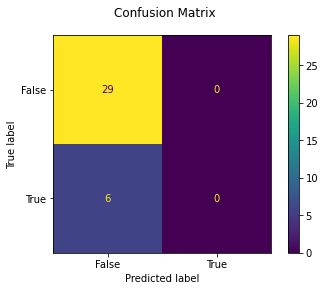

In [8]:
# TRAIN, PREDICT, GRAPH
X_train, X_test, y_train, y_test = train_test_split(one_hots, are_early, random_state=1, test_size=0.2)
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation="relu", random_state=1).fit(X_train_scaled, y_train)
y_pred=clf.predict(X_test_scaled)
print(clf.score(X_test_scaled, y_test))

fig=plot_confusion_matrix(clf, X_test_scaled, y_test)
fig.figure_.suptitle("Confusion Matrix")
plt.show()